## Work
1. 請嘗試寫一個 callback 用來記錄各類別在訓練過程中，對驗證集的 True Positive 與 True Negative

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization
from keras.callbacks import Callback
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [3]:
(x_train, y_train),(x_test, y_test ) = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 37s 0us/step


In [0]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [0]:
# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [0]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    
    model = Sequential()
    model.add(Dense(units = input_shape[1] ,input_dim = input_shape[1], kernel_initializer = 'normal', activation = 'relu',name = 'input'))
    
    for i, n_units in enumerate(num_neurons):
        model.add(Dense(units=n_units, kernel_initializer='normal', activation='relu',name="hidden_layer"+str(i+1)))  
        model.add(BatchNormalization())         
    
    model.add(Dense(units=output_units,kernel_initializer='normal', activation='softmax',name='output'))

    return model

In [0]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [0]:
# Record_fp_tp
class Record_tp_tn(Callback):
    def on_train_begin(self, epoch, logs = {}):
        logs = logs or {}
        record_items = ["val_auc", "val_f1sc", "val_fp", "val_fn", "val_tp", "val_tn"]
        for i in record_items:
            if i not in self.params['metrics']:
                self.params['metrics'].append(i)
    
    def on_epoch_end(self, epoch, logs = {}, thres=0.5):
        logs = logs or {}
        y_true = self.validation_data[1].argmax(axis = 1)
        y_pred = self.model.predict(self.validation_data[0])
        y_pred = (y_pred[:, 1] >= thres) * 1
        
        CM=confusion_matrix(y_true, y_pred)
        logs['val_tp'] =CM[0][0]
        logs['val_tn'] =CM[1][1]
        
rec_tptn = Record_tp_tn()

In [9]:
model = build_mlp(input_shape=x_train.shape)
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[rec_tptn]
         )
# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

valid_tp = model.history.history["val_tp"]
valid_tn = model.history.history["val_tn"]

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 3072)              9440256   
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batc

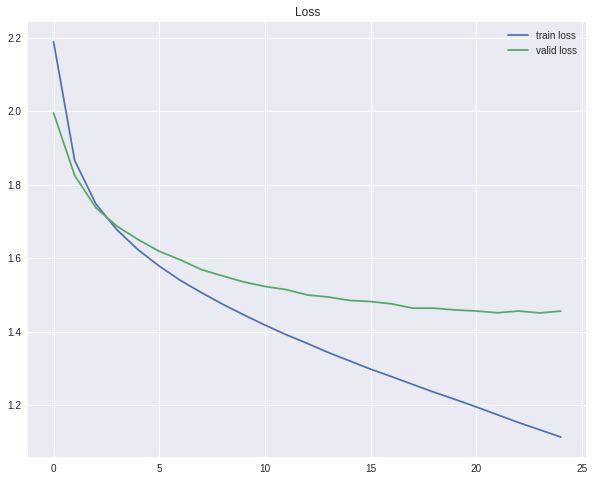

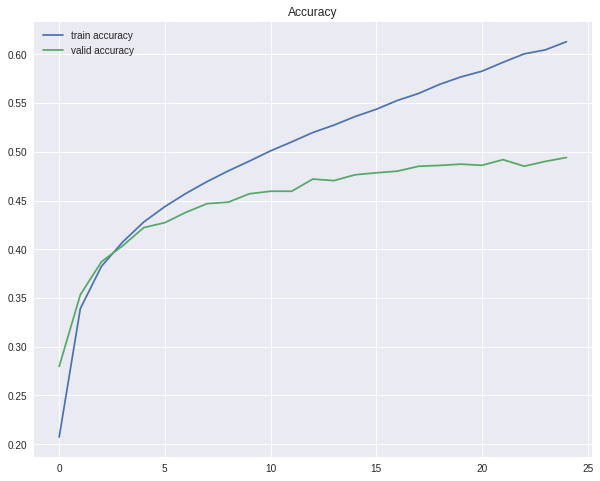

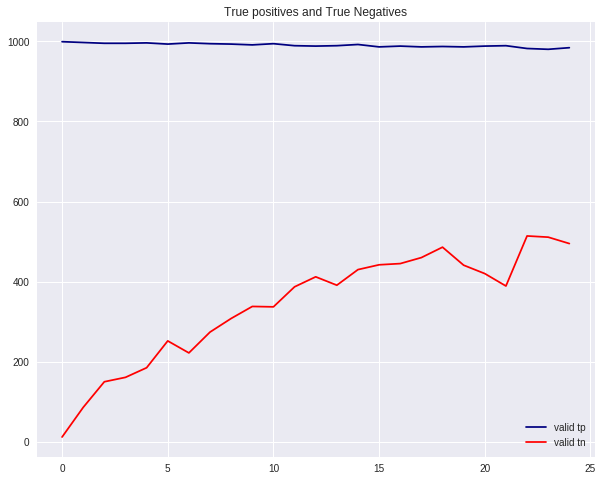

In [12]:
plt.figure(figsize=(10,8))
plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.figure(figsize=(10,8))
plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

plt.figure(figsize=(10,8))
plt.plot(range(len(valid_tp)), valid_tp, label="valid tp", color="navy")
plt.plot(range(len(valid_tn)), valid_tn, label="valid tn", color="red")
plt.legend()
plt.title("True positives and True Negatives")
plt.show()
